In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

Pkg.add("MeshCat")
Pkg.add("GeometryBasics")
Pkg.add("CoordinateTransformations")
Pkg.add("DifferentiableCollisions")
Pkg.add("StaticArrays")
Pkg.add("MeshCatMechanisms")
Pkg.add("RigidBodyDynamics")
Pkg.add("LinearAlgebra")
Pkg.add("Rotations")
Pkg.add("Plots")
using Rotations
using LinearAlgebra
using RigidBodyDynamics
using MeshCat
using GeometryBasics
using CoordinateTransformations
using StaticArrays
using MeshCatMechanisms
using Plots

  Activating environment at `~/tiltrotor_control/Project.toml`


    Updating registry at `~/.julia/registries/General`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


In [ ]:
function animate_tiltrotor(X, dt)
    vis = Visualizer()
    urdf = joinpath(@__DIR__,"urdf/tiltrotor.urdf")
    robot = parse_urdf(urdf)
    remove_fixed_tree_joints!(robot)

    mvis = MechanismVisualizer(robot, URDFVisuals(urdf), vis)
    # settransform!(vis, Translation(0., 0, 3))
    # set_configuration!(mvis, [1.5, -1.5])
    anim = Animation(floor(Int,1/dt))
    for k = 1:length(X)
        atframe(anim, k) do
            q = QuatRotation(X[k][4], X[k][5], X[k][6], X[k][7])
            settransform!(vis, Translation(X[k][1], X[k][2], X[k][3]) ∘ LinearMap(RotXYZ(q)))
            set_configuration!(mvis, [X[k][14], X[k][15]])
        end
    end
    setanimation!(vis, anim)
    return render(vis)
end
display(animate_tiltrotor(1.5:-0.1:0.7, 0.1))

## Dynamics

Type out dynamics here

In [2]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end

function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end

T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]

function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end

function G(q)
    G = L(q)*H
end

function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end

function qtorp(q)
    q[2:4]/q[1]
end

qtorp (generic function with 1 method)

In [3]:
# Coefficient of lift and drag for the wing (DAE 51 airfoil)

function C_l(α)
    return -7e-6*α^3 - 0.0013*α^2 + 0.0563*α + 0.4683
end

function C_d(α)
    return -4e-6*α^3 - 0.0005*α^2 + 0.0008*α + 0.0269
end

C_d (generic function with 1 method)

In [4]:
function tiltrotor_dynamics(model::NamedTuple,x,u)
    r = x[1:3]
    q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
    v = x[8:10]
    ω = x[11:13]
    δ_l = x[14]
    δ_r = x[15]

    Q = qtoQ(q)

    m = model.m
    g = model.g
    J = model.J
    
    ṙ = Q*v
    q̇ = 0.5*L(q)*H*ω

    # Propeller forces
    F_l = model.k_F*u[1]
    F_r = model.k_F*u[2]

    # Force due to gravity
    F_g = [0; 0; -m*g]
    
    # Force due to propellers
    F_thrusters = [F_r*sin(δ_r) + F_l*sin(δ_l); 0; F_r*cos(δ_r) + F_l*cos(δ_l)]
    
    # Force due to wings
    α = -atan(v[3], v[1]) #Angle of attack
    q = 0.5*model.ρ*(v[1]^2 + v[3]^2)
    L_wing = [0; 0; q*model.S_wing*C_l(α)] #Lift force
    D_wing = [-q*model.S_wing*C_d(α); 0; 0] #Drag force

    # Total external force acting in the body frame
    F_ext = Q'*F_g + F_thrusters + L_wing + D_wing
    
    # Acceleration in the body frame
    v̇ = (1/m)*F_ext - hat(ω)*v

    # Propeller moments
    M_l = model.k_τ*u[1]
    M_r = -model.k_τ*u[2]

    # Moments due to propellers
    M_thrusters = [M_r*sin(δ_r) + M_l*sin(δ_l); 0; M_r*cos(δ_r) + M_l*cos(δ_l)]
    
    # Total external torque acting in the body frame
    τ_ext = [(-F_r*cos(δ_r) + F_l*cos(δ_l))*model.b/2; 0; (F_r*sin(δ_r) - F_l*sin(δ_l))*model.b/2] + M_thrusters
    omega_dot = J\(-hat(ω)*J*ω + τ_ext)

    # Propeller angle rate
    δ_l_dot = u[3]
    δ_r_dot = u[4]
    
    return [ṙ; q̇; v̇; omega_dot; δ_l_dot; δ_r_dot]
end

tiltrotor_dynamics (generic function with 1 method)

In [5]:
function tiltrotor_dynamics_rk4(model,x,u)
    #RK4 integration with zero-order hold on u
    h = model.dt
    f1 = tiltrotor_dynamics(model, x, u)
    f2 = tiltrotor_dynamics(model, x + 0.5*h*f1, u)
    f3 = tiltrotor_dynamics(model, x + 0.5*h*f2, u)
    f4 = tiltrotor_dynamics(model, x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

tiltrotor_dynamics_rk4 (generic function with 1 method)

In [6]:
model = (m=1.8,
        J=Diagonal([0.1365, 0.04401, 0.1802]),
        g=9.81,
        k_F=5.15e-5,
        k_τ=1e-6,
        k_δ=0.5,
        ρ=1.225,
        S_wing=0.325,
        b = 1,
        dt = 0.05)

Nx = 15     # number of states (quaternion)
Nx̃ = 14     # number of states (linearized)
Nu = 4     # number of controls
Tfinal = 1.0 # final time
Nt = Int(Tfinal/model.dt)+1    # number of time steps
thist = Array(range(0,model.dt*(Nt-1), step=model.dt));

In [7]:
#Initial Conditions
uhover = ((model.m*model.g/2)/model.k_F)*ones(4)
uhover[3] = 0
uhover[4] = 0
r0 = [0.0; 0.0; 1.0]
q0 = [1.0; 0; 0; 0]
v0 = zeros(3)
ω0 = zeros(3)
δ_l_dot0 = 0
δ_r_dot0 = 0
x0 = [r0; q0; v0; ω0; δ_l_dot0; δ_r_dot0];

In [8]:
#Simulation
xhist = zeros(Nx,Nt)
xhist[:,1] = [r0; q0; v0; ω0; δ_l_dot0; δ_r_dot0];
for k = 1:(Nt-1)
    xhist[:,k+1] = tiltrotor_dynamics_rk4(model,xhist[:,k],uhover)
end

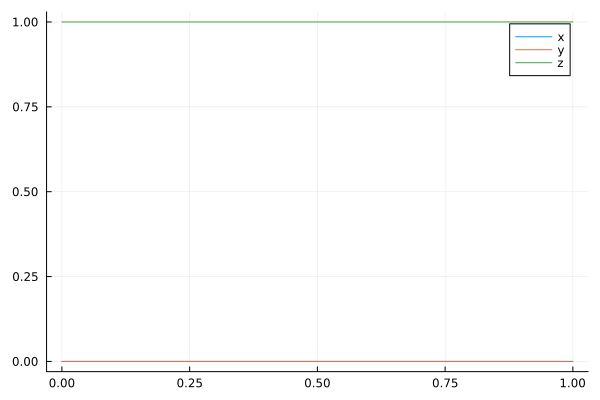

In [9]:
# Plot the results
plot(thist, xhist[1:3,:]', label=["x" "y" "z"])
# plot(thist, xhist[4:7,:]', label=["q0" "q1" "q2" "q3"])
# plot(thist, xhist[8:10,:]', label=["vx" "vy" "vz"])
# plot(thist, xhist[11:13,:]', label=["wx" "wy" "wz"])
# plot(thist, xhist[14:15,:]', label=["δ_l" "δ_r"])

## State Vector

X = [r, q, v, ω, δ_l, δ_l]

- r -> position in world frame
- v -> velocity in world frame
- q -> quaternion rotation
- ω -> angular velocity
- δ_l -> tilt of left rotor
- δ_r -> tilt of right rotor

## Control Vector

U = [ω_l, ω_r, δ_l_dot, δ_r_dot]

- ω_l -> speed (rad/s) of left rotor
- ω_r -> speed (rad/s) of right rotor 
- δ_l_dot -> rate of change of left rotor tilt
- δ_r_dot -> rate of change of right rotor tilt

## Integration

In [ ]:
function discrete_dynamics(params::NamedTuple, x::Vector, u, k)
    # discrete dynamics
    # x - state 
    # u - control 
    # k - index of trajectory 
    # dt comes from params.model.dt 
    return rk4(params.model, tiltrotor_dynamics, x, u, params.model.dt)
end

## Cost

DIRCOL or iLQR?

## Trajectory Optimization

In [ ]:
# # dynamics parameters (taken from HW3)
# model = (mass=0.5,
#         J=Diagonal([0.0023, 0.0023, 0.004]),
#         gravity=[0,0,-9.81],
#         L=0.1750,
#         kf=1.0,
#         km=0.0245,dt = dt)

# dynamics parameters (taken from HW3)

model = (mass=1.8,
        J=Diagonal([0.1365, 0.04401, 0.1802]),
        g=9.81,
        k_F=5.15e-5,
        k_δ=0.5,
        ρ=1.225,
        S_wing=0.325,
        moment_matrix=[0 0 0.5;
                       0 0 -0.1;
                       -0.5 0.1 0],
        dt = dt)

## Tracking with TVLQR

## Visualize